In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import wfdb
import pandas as pd
import ast
import random
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim

import tensorflow as tf
import tensorflow.keras as keras
import keras.metrics as metrics

import data_visualisation as dv
import data_augmentation as da
# from PTBXL import PTBXL
import importlib

importlib.reload(dv)
importlib.reload(da)



2024-04-18 16:59:51.403552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 16:59:51.919301: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-18 16:59:51.919362: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-18 16:59:51.919368: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

<module 'data_augmentation' from '/home/raaif/Desktop/Uni/y4/FYP/data_augmentation.py'>

In [2]:
# Load the data
brugada_path = 'DAT China/DAT China Brugada ECGs/dat'
RBBB_path = 'DAT China/DAT China RBBB ECGs/datnew'
Normal_path = 'DAT China/Normal/dat'

In [3]:
def load_china_data(dir_path, label):
    
    # init array
    data = []
    
    # read all files in the directory
    for file in os.listdir(dir_path):
        path = os.path.join(dir_path, file)
        f = open(path, 'r')
        ecg = np.fromfile(f, dtype=np.int16)
        ecg = np.reshape(ecg, (8, 5000))
        
        ## Downsample to 100hz
        ecg = ecg.reshape(8, 1000, 5)
        ecg = np.mean(ecg, axis=2)
        
        data.append(ecg)
        f.close()
        
    # Convert to numpy array
    data = np.array(data)
    # Reshape to (n_samples, n_samples_per_lead, n_leads)
    data = np.swapaxes(data, 1, 2)
    
    # Calculate remaining leads
    lead_III = data[:,:,1] - data[:,:,0]           # ecg_dict['III'] = ecg_dict['II'] - ecg_dict['I']
    lead_aVR = -0.5 * (data[:,:,0] + data[:,:,1])  # ecg_dict['aVR'] = -0.5 * (ecg_dict['I'] + ecg_dict['II'])
    lead_aVL = data[:,:,0] - 0.5 * data[:,:,1]     # ecg_dict['aVL'] = ecg_dict['I'] - 0.5 * ecg_dict['II']
    lead_aVF = data[:,:,1] - 0.5 * data[:,:,0]     # ecg_dict['aVF'] = ecg_dict['II'] - 0.5 * ecg_dict['I']
    
    # Add remaining leads to data
    data = np.concatenate((data,  
                              np.expand_dims(lead_III, axis=2), 
                              np.expand_dims(lead_aVR, axis=2), 
                              np.expand_dims(lead_aVL, axis=2), 
                              np.expand_dims(lead_aVF, axis=2)), axis=2)
    
    return data, np.full(data.shape[0], label)

In [4]:
# get first file from brugada folder
brugada_files = os.listdir(brugada_path)
RBBB_files = os.listdir(RBBB_path)
Normal_files = os.listdir(Normal_path)

# Load the data
brugada_data = []
RBBB_data = []
Normal_data = []

# load all Normals
for file in Normal_files:
    path = os.path.join(Normal_path, file)
    f = open(path, 'r')
    ecg = np.fromfile(f, dtype=np.int16)
    ecg = np.reshape(ecg, (8, 5000))
    Normal_data.append(ecg)
    f.close()

# Convert to numpy array
Normal_data = np.array(Normal_data)
# Reshape to (n_samples, n_samples_per_lead, n_leads)
Normal_data = np.swapaxes(Normal_data, 1, 2)

# calculate remaining leads
lead_III = Normal_data[:,:,1] - Normal_data[:,:,0]           # ecg_dict['III'] = ecg_dict['II'] - ecg_dict['I']
lead_aVR = -0.5 * (Normal_data[:,:,0] + Normal_data[:,:,1])  # ecg_dict['aVR'] = -0.5 * (ecg_dict['I'] + ecg_dict['II'])
lead_aVL = Normal_data[:,:,0] - 0.5 * Normal_data[:,:,1]     # ecg_dict['aVL'] = ecg_dict['I'] - 0.5 * ecg_dict['II']
lead_aVF = Normal_data[:,:,1] - 0.5 * Normal_data[:,:,0]     # ecg_dict['aVF'] = ecg_dict['II'] - 0.5 * ecg_dict['I']

# Add remaining leads to data
Normal_data = np.concatenate((Normal_data, 
                              np.expand_dims(lead_III, axis=2), 
                              np.expand_dims(lead_aVR, axis=2), 
                              np.expand_dims(lead_aVL, axis=2), 
                              np.expand_dims(lead_aVF, axis=2)), axis=2)
    

In [5]:
Normal_data, normal_labels = load_china_data(Normal_path, 0)
brugada_data, brugada_labels = load_china_data(brugada_path, 1)
RBBB_data, RBBB_labels = load_china_data(RBBB_path, 0)

(1000, 12)


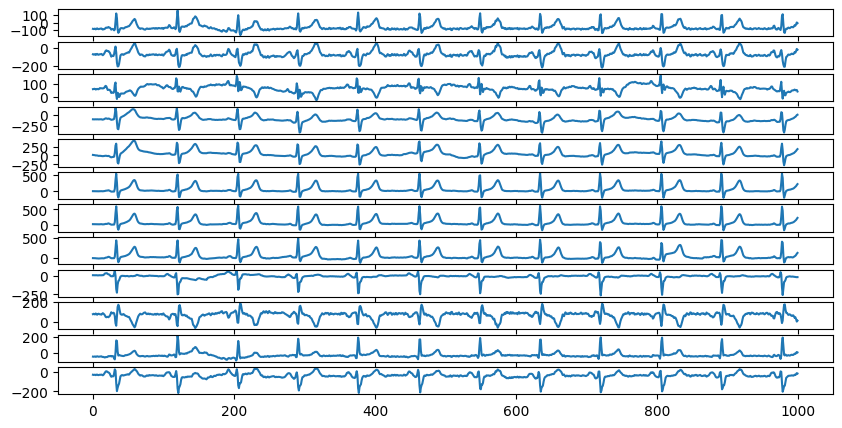

In [6]:
rand_sample = Normal_data[np.random.randint(0, Normal_data.shape[0])]
# rand_sample = Normal_data[0]
print(rand_sample.shape)

bar, axes = plt.subplots(rand_sample.shape[1], 1, figsize=(10,5))
for i in range(rand_sample.shape[1]):
    sns.lineplot(x=np.arange(rand_sample.shape[0]), y=rand_sample[:, i], ax=axes[i])

In [7]:
# Downsample for training

#original data
print("Original data")
print("Normal:", Normal_data.shape)
print("RBBB:", RBBB_data.shape)
print("Burgada:", brugada_data.shape)

Normal_ratio = 0.02
RBBB_ratio = 0.01

# get random samples
Normal_downsampled = Normal_data[np.random.choice(Normal_data.shape[0], int(Normal_data.shape[0] * Normal_ratio), replace=False)]
RBBB_downsampled = RBBB_data[np.random.choice(RBBB_data.shape[0], int(RBBB_data.shape[0] * RBBB_ratio), replace=False)]
Bruagada_downsampled = brugada_data

print("\nDownsampled data")
print("Normal:", Normal_downsampled.shape)
print("RBBB:", RBBB_downsampled.shape)
print("Burgada:", Bruagada_downsampled.shape)


Original data
Normal: (9998, 1000, 12)
RBBB: (10000, 1000, 12)
Burgada: (176, 1000, 12)

Downsampled data
Normal: (199, 1000, 12)
RBBB: (100, 1000, 12)
Burgada: (176, 1000, 12)


In [8]:
# shuffle data
np.random.shuffle(Normal_downsampled)
np.random.shuffle(RBBB_downsampled)
np.random.shuffle(Bruagada_downsampled)

data = np.concatenate((Normal_downsampled, RBBB_downsampled, Bruagada_downsampled), axis=0)
labels = np.concatenate((normal_labels[:Normal_downsampled.shape[0]], RBBB_labels[:RBBB_downsampled.shape[0]], brugada_labels), axis=0)

print("\nData shape:", data.shape)
print("Labels shape:", labels.shape)

# shuffle data
permutation = np.random.permutation(data.shape[0])
np.random.shuffle(permutation)

shuffled_data = data[permutation]
shuffled_labels = labels[permutation]


Data shape: (475, 1000, 12)
Labels shape: (475,)


In [9]:
# get a test, train, validation split
train_split = 0.7
val_split = 0.1
test_split = 0.2

train_data = shuffled_data[:int(shuffled_data.shape[0] * train_split)]
train_labels = shuffled_labels[:int(shuffled_labels.shape[0] * train_split)]

val_data = shuffled_data[int(shuffled_data.shape[0] * train_split):int(shuffled_data.shape[0] * (train_split + val_split))]
val_labels = shuffled_labels[int(shuffled_labels.shape[0] * train_split):int(shuffled_labels.shape[0] * (train_split + val_split))]

test_data = shuffled_data[int(shuffled_data.shape[0] * (train_split + val_split)):]
test_labels = shuffled_labels[int(shuffled_labels.shape[0] * (train_split + val_split)):]

In [10]:
NP_DATA_LR = 'data/DAT_China.npz'

save_args = {
    'X_train': train_data,
    'y_train': train_labels,
    'X_val': val_data,
    'y_val': val_labels,
    'X_test': test_data,
    'y_test': test_labels
}

np.savez(NP_DATA_LR, **save_args)

In [11]:
thismodule = sys.modules[__name__]
NP_DATA = 'data/DAT_China.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if k == 'y_train_text':
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))

In [12]:
from sklearn.preprocessing import StandardScaler



# Normalise data
X_scaler = StandardScaler()
X_scaler.fit(X_train.reshape(-1, X_train.shape[-1]))

X_train = X_scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = X_scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test  = X_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(332, 1000, 12)
(332,)
(47, 1000, 12)
(47,)
(96, 1000, 12)
(96,)


(1000, 12)
1.0


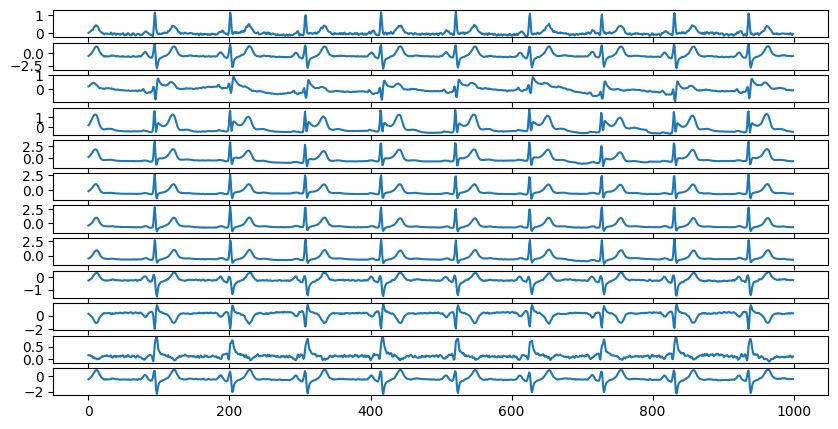

In [37]:
rand_index = np.random.randint(0, X_train.shape[0])
rand_sample = X_train[rand_index]
label = y_train[rand_index]
# rand_sample = Normal_data[0]
print(rand_sample.shape)
print(label)

bar, axes = plt.subplots(rand_sample.shape[1], 1, figsize=(10,5))
for i in range(rand_sample.shape[1]):
    sns.lineplot(x=np.arange(rand_sample.shape[0]), y=rand_sample[:, i], ax=axes[i])

(1000, 12)
1.0


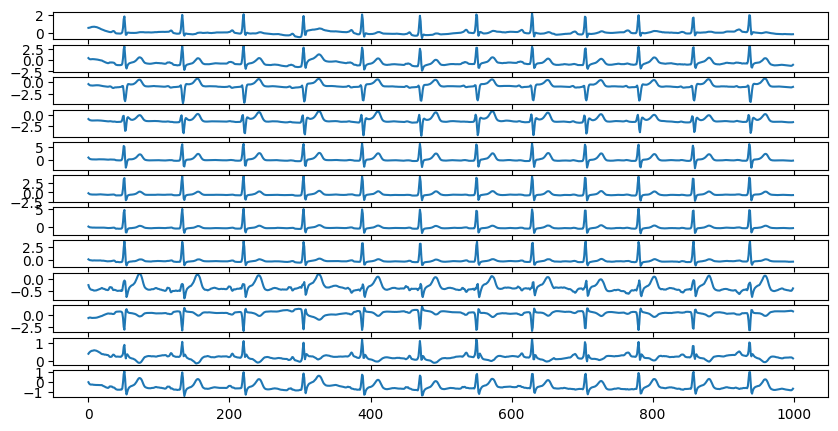

In [49]:
rand_index = np.random.randint(0, X_train.shape[0])
rand_sample = X_train[rand_index]
label = y_train[rand_index]
# rand_sample = Normal_data[0]
print(rand_sample.shape)
print(label)

bar, axes = plt.subplots(rand_sample.shape[1], 1, figsize=(10,5))
for i in range(rand_sample.shape[1]):
    sns.lineplot(x=np.arange(rand_sample.shape[0]), y=rand_sample[:, i], ax=axes[i])

In [15]:
def cnn_model(X, num_classes=5, filters = [32, 64, 128], kernels = [5,3,3]):
    
    X = keras.layers.Conv1D(filters=filters[0], kernel_size=kernels[0], input_shape=X.shape[1:])(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation('relu')(X)
    
    X = keras.layers.MaxPooling1D(2)(X)
    
    X = keras.layers.Conv1D(filters=filters[1], kernel_size=kernels[1])(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation('relu')(X)
    
    X = keras.layers.MaxPooling1D(2)(X)
    
    X = keras.layers.Conv1D(filters=filters[2], kernel_size=kernels[2])(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation('relu')(X)
    
    features_output = keras.layers.GlobalAveragePooling1D()(X)
    X = keras.layers.Dropout(0.5)(features_output)
    
    X = keras.layers.Dense(128, activation='relu')(X)
    X = keras.layers.Dense(num_classes, activation='sigmoid')(X)
    
    
    return X, features_output

X_input = keras.Input(shape=X_train.shape[1:])
num_classes = 1
_, feature_extractor = cnn_model(X_input, num_classes=num_classes)

2024-04-18 17:00:01.578220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-18 17:00:01.606585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-18 17:00:01.606838: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-18 17:00:01.607229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [16]:
feature_extractor_model = keras.Model(inputs=X_input, outputs=feature_extractor)
feature_extractor_model.load_weights('models/cnn_model.keras', by_name=True)
for layer in feature_extractor_model.layers:
    layer.trainable = False
    
X = keras.layers.Dense(128, activation='relu')(feature_extractor)
X_out = keras.layers.Dense(num_classes, activation='sigmoid')(X)

new_model = keras.Model(inputs=X_input, outputs=X_out)
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC()])

In [19]:
history = new_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1)

Epoch 1/100


11/11 [==============================] - 0s 6ms/step - loss: 0.3575 - accuracy: 0.8464 - precision: 0.8544 - recall: 0.7097 - auc: 0.9307 - val_loss: 0.4692 - val_accuracy: 0.8298 - val_precision: 0.7778 - val_recall: 0.5385 - val_auc: 0.9321
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 0.3565 - accuracy: 0.8524 - precision: 0.8713 - recall: 0.7097 - auc: 0.9307 - val_loss: 0.5370 - val_accuracy: 0.8085 - val_precision: 0.7000 - val_recall: 0.5385 - val_auc: 0.9140
Epoch 3/100
11/11 [==============================] - 0s 5ms/step - loss: 0.3570 - accuracy: 0.8554 - precision: 0.8455 - recall: 0.7500 - auc: 0.9296 - val_loss: 0.4850 - val_accuracy: 0.8298 - val_precision: 0.7778 - val_recall: 0.5385 - val_auc: 0.9231
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.3635 - accuracy: 0.8343 - precision: 0.8710 - recall: 0.6532 - auc: 0.9276 - val_loss: 0.5605 - val_accuracy: 0.8085 - val_precision: 0.7000 - val_recall: 0.5385 - val_auc:

In [25]:
from sklearn.metrics import classification_report, f1_score, accuracy_score

# evaluate the model
y_pred = new_model.predict(X_test)
y_pred_binary = np.round(y_pred)
y_true = y_test

print(classification_report(y_true, y_pred_binary))

# AUC score
from sklearn.metrics import roc_auc_score

print("AUC score:", roc_auc_score(y_true, y_pred))
print("F1 score:", f1_score(y_true, y_pred_binary))
print("Accuracy score:", accuracy_score(y_true, y_pred_binary))

3/3 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.75      0.95      0.84        57
         1.0       0.88      0.54      0.67        39

    accuracy                           0.78        96
   macro avg       0.81      0.74      0.75        96
weighted avg       0.80      0.78      0.77        96

AUC score: 0.9073324336482231
F1 score: 0.6666666666666667
Accuracy score: 0.78125


In [52]:
model2, _ = cnn_model(X_input, num_classes=num_classes)

model2 = keras.Model(inputs=X_input, outputs=model2)
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC()])
history2 = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
11/11 [==============================] - 2s 25ms/step - loss: 0.6632 - accuracy: 0.6145 - precision_4: 0.4375 - recall_4: 0.1129 - auc_4: 0.5487 - val_loss: 0.6955 - val_accuracy: 0.3617 - val_precision_4: 0.3023 - val_recall_4: 1.0000 - val_auc_4: 0.8190
Epoch 2/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6148 - accuracy: 0.7078 - precision_4: 0.7077 - recall_4: 0.3710 - auc_4: 0.6739 - val_loss: 0.7358 - val_accuracy: 0.2766 - val_precision_4: 0.2766 - val_recall_4: 1.0000 - val_auc_4: 0.7353
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5638 - accuracy: 0.7048 - precision_4: 0.7097 - recall_4: 0.3548 - auc_4: 0.7931 - val_loss: 0.6616 - val_accuracy: 0.7447 - val_precision_4: 0.5294 - val_recall_4: 0.6923 - val_auc_4: 0.7862
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5090 - accuracy: 0.7560 - precision_4: 0.9057 - recall_4: 0.3871 - auc_4: 0.8366 - val_loss: 0.6316 - val_accuracy: 0.7872 

In [53]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# evaluate the model
y_pred = model2.predict(X_test)
y_pred_binary = np.round(y_pred)
y_true = y_test

print(classification_report(y_true, y_pred_binary))



print("Accuracy score:", accuracy_score(y_true, y_pred_binary))
print("F1 score:", f1_score(y_true, y_pred_binary))
print("Precision score:", precision_score(y_true, y_pred_binary))
print("Recall score:", recall_score(y_true, y_pred_binary))
print("AUC score:", roc_auc_score(y_true, y_pred))

3/3 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96        57
         1.0       0.97      0.90      0.93        39

    accuracy                           0.95        96
   macro avg       0.95      0.94      0.95        96
weighted avg       0.95      0.95      0.95        96

Accuracy score: 0.9479166666666666
F1 score: 0.9333333333333333
Precision score: 0.9722222222222222
Recall score: 0.8974358974358975
AUC score: 0.9851551956815114
